### Goal: In-hospital mortality prediction

Resource: 

https://pmc.ncbi.nlm.nih.gov/articles/PMC9592355/

Import necessary libraries

In [2]:
# for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# for machine learning models 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [3]:
DATABASE_DIR = "mimic-database/mimic-iii-clinical-database-1.4" 
# For demo data
# DATABASE_DIR = "mimic-database/demo" 

In [4]:
patients = pd.read_csv(f'{DATABASE_DIR}/PATIENTS.csv')

In [5]:
# Load data
admissions = pd.read_csv(f'{DATABASE_DIR}/ADMISSIONS.csv')
patients = pd.read_csv(f'{DATABASE_DIR}/PATIENTS.csv')
inputevents_mv = pd.read_csv(f'{DATABASE_DIR}/INPUTEVENTS_MV.csv')

### parallel loading of large dataframes

In [6]:
def read_csv_with_progress(file_path, sep):
    import pandas as pd
    from tqdm import tqdm

    chunk_size = 50000  # Number of lines to read in each iteration

    # Get the total number of lines in the CSV file
    print("Calculating average line length + getting file size")
    counter = 0
    total_length = 0
    num_to_sample = 10
    for line in open(file_path, 'r'):
        counter += 1
        if counter > 1:
            total_length += len(line)
        if counter == num_to_sample + 1:
            break
    file_size = os.path.getsize(file_path)
    avg_line_length = total_length / num_to_sample
    avg_number_of_lines = int(file_size / avg_line_length)

    chunks = []
    with tqdm(total=avg_number_of_lines, desc='Reading CSV') as pbar:
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False, sep=sep):
            chunks.append(chunk)
            pbar.update(chunk.shape[0])

    print("Concating...")
    df = pd.concat(chunks, ignore_index=True)
    return df


In [ ]:
d_lab_items = read_csv_with_progress(f'{DATABASE_DIR}/D_LABITEMS.csv', sep=',')
labevents = read_csv_with_progress(f'{DATABASE_DIR}/LABEVENTS.csv', sep=',')

Calculating average line length + getting file size


Reading CSV: 753it [00:00, 148319.29it/s]           

Concating...


In [8]:
labevents = read_csv_with_progress(f'{DATABASE_DIR}/LABEVENTS.csv', sep=',')

Calculating average line length + getting file size


Reading CSV:  78%|███████▊  | 27854055/35727276 [00:12<00:03, 2304338.23it/s]


Concating...


### loading chartevents fail 

In [180]:
chartevents = read_csv_with_progress(f'{DATABASE_DIR}/CHARTEVENTS.csv', sep=',')

Calculating average line length + getting file size


Reading CSV:  86%|████████▌ | 330712483/385037024 [04:01<00:39, 1368453.11it/s]


Concating...


: 

### trying a different approach to load chartevents

In [ ]:
import pandas as pd
import glob
import os

# Get the directory path where your split files are located
directory_path = f'{DATABASE_DIR}/chartevents_split'

# Get all split files
file_pattern = os.path.join(directory_path, 'split_file_*')
files = sorted(glob.glob(file_pattern))

files = files[:10]

print(f"Found {len(files)} split files")

# Specify only the columns you want to read
columns_to_read = ['SUBJECT_ID', 'CHARTTIME', 'ITEMID', 'VALUE', 'VALUENUM']

dfs = []
for file in files: 
    print(f"Reading {file}...")
    
    # Use usecols parameter to specify only certain columns
    df = pd.read_csv(file, sep=',', )
    
    dfs.append(df)
    print(f"Done reading {file}, shape: {df.shape}")

Found 10 split files
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_aa.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_aa.csv, shape: (10795224, 15)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ab.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ab.csv, shape: (10641151, 11)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ac.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ac.csv, shape: (10571604, 10)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ad.csv...


/var/folders/4v/np_9tc295nv6q1gh0_nypyfh0000gn/T/ipykernel_85221/2829545283.py:24: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep=',', )


Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ad.csv, shape: (9863730, 14)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ae.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ae.csv, shape: (9696264, 11)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_af.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_af.csv, shape: (9697031, 9)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ag.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ag.csv, shape: (9700031, 8)
Reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ah.csv...
Done reading mimic-database/mimic-iii-clinical-database-1.4/chartevents_split/split_file_ah.csv, shape: (9708084, 8)
Reading mimic-database/mimic-iii-clin

In [10]:
chartevents = pd.concat(dfs, ignore_index=True)
print(f"Combined DataFrame shape: {chartevents.shape}")


Combined DataFrame shape: (99941372, 71)


In [11]:
# If you want to free up memory
del dfs

In [12]:
chunk_size = 100000  # Adjust based on your available memory
for i in range(0, len(chartevents), chunk_size):
    chunk = chartevents.iloc[i:i+chunk_size]
    chunk_clean = chunk.dropna()

In [13]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [14]:
# only for demo data, since the column names are lowercase in demo data and uppercase in the full dataset
patients.columns = patients.columns.str.upper()
admissions.columns = admissions.columns.str.upper()
inputevents_mv.columns = inputevents_mv.columns.str.upper()
chartevents.columns = chartevents.columns.str.upper()
labevents.columns = labevents.columns.str.upper()
d_lab_items.columns = d_lab_items.columns.str.upper()

### helper functions to calculate age and hospital stay

In [15]:
# Calculate age function
def calculate_age(dob, admit):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    admit_date = datetime.strptime(admit, "%Y-%m-%d %H:%M:%S")
    age = (admit_date - dob_date).days // 365
    return age

In [16]:
def calculate_hospital_stay(admit, discharge):
    admit_dt = datetime.strptime(admit, '%Y-%m-%d %H:%M:%S')
    discharge_dt = datetime.strptime(discharge, '%Y-%m-%d %H:%M:%S')

    duration = (discharge_dt - admit_dt)

    return duration.total_seconds()/(24*3600)

In [36]:
final_df = admissions.merge(patients, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
final_df['age'] = final_df.apply(lambda x: calculate_age(x['DOB'], x['ADMITTIME']), axis=1)
final_df['hospital_stay'] = final_df.apply(lambda x: calculate_hospital_stay(x['ADMITTIME'], x['DISCHTIME']), axis=1)

In [37]:
final_df['ADMISSION_LOCATION'].describe()

count                    58976
unique                       9
top       EMERGENCY ROOM ADMIT
freq                     22754
Name: ADMISSION_LOCATION, dtype: object

In [38]:
final_df.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,age,hospital_stay
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0,64,1.144444
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,71,5.496528
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,75,6.768056
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0,39,2.856944
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0,58,3.534028


In [39]:
d_lab_items['LABEL'].str.contains('Sodium', na=False).unique()
sodium_items = d_lab_items[d_lab_items['LABEL'].str.contains('Sodium', na=False)]
sodium_items

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
151,25,50824,"Sodium, Whole Blood",Blood,Blood Gas,2947-0
161,35,50834,"Sodium, Body Fluid",Other Body Fluid,Blood Gas,2950-4
175,49,50848,"Sodium, Ascites",Ascites,Chemistry,49790-9
310,184,50983,Sodium,Blood,Chemistry,2951-2
368,242,51042,"Sodium, Body Fluid",Other Body Fluid,Chemistry,2950-4
384,258,51058,"Sodium, Pleural",Pleural,Chemistry,NaN
391,265,51065,"Sodium, Stool",Stool,Chemistry,15207-4
426,300,51100,"Sodium, Urine",Urine,Chemistry,2955-3


In [40]:
# sodium whole blood, Potassium, Whole Blood, Calcium Total, Glucose
electrolytes_lab = labevents[labevents['ITEMID'].isin([50824, 50822, 50893, 50809])]

electrolytes_lab = electrolytes_lab[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM', 'VALUEUOM']]

electrolytes_lab['ELECTROLYTE'] = electrolytes_lab['ITEMID'].map({
    50824: 'NA+',
    50822: 'K+',
    50893: 'CA+', 
    50809: 'GLUCOSE'
})

electrolytes_lab.head()

electrolytes_lab = electrolytes_lab.pivot_table(
    index=['SUBJECT_ID', 'HADM_ID'],
    columns='ELECTROLYTE',
    values='VALUENUM',
    aggfunc='mean'  # Use mean for multiple measurements
).reset_index()

final_df = final_df.merge(
    electrolytes_lab,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

final_df

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,age,hospital_stay,CA+,GLUCOSE,K+,NA+
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,64,1.144444,9.050000,NaN,NaN,NaN
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,71,5.496528,8.000000,113.7,3.83,139.75
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,75,6.768056,8.687500,131.5,3.45,136.50
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,NaN,NaN,NaN,0,39,2.856944,9.475000,NaN,NaN,NaN
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,NaN,NaN,NaN,0,58,3.534028,7.950000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,NaN,NaN,NaN,0,19,2.742361,7.540000,99.0,3.30,141.00
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,2151-03-06 00:00:00,2151-03-06 00:00:00,NaN,1,83,0.548611,NaN,258.0,4.20,138.00
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,NaN,NaN,NaN,0,42,8.203472,8.283333,130.5,4.75,137.50
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,NaN,NaN,NaN,0,60,41.445833,8.276923,154.0,3.95,144.00


In [41]:
final_df = final_df.dropna(subset=['CA+', 'NA+', 'K+', 'GLUCOSE'])
final_df

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,age,hospital_stay,CA+,GLUCOSE,K+,NA+
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,71,5.496528,8.000000,113.70,3.830000,139.75
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,75,6.768056,8.687500,131.50,3.450000,136.50
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,74,5.364583,8.000000,130.50,4.466667,136.50
10,31,32,175413,2170-04-04 08:00:00,2170-04-23 12:45:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,...,NaN,NaN,NaN,0,45,19.197917,8.457143,125.00,4.071429,143.00
13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,2192-01-30 00:00:00,NaN,2192-01-30 00:00:00,1,304,2.622917,8.600000,116.00,4.800000,143.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58969,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,0,78,4.145833,8.900000,128.25,4.175000,139.00
58970,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,2132-12-25 00:00:00,2132-12-25 00:00:00,NaN,1,88,0.662500,7.850000,163.00,4.600000,148.00
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,NaN,NaN,NaN,0,19,2.742361,7.540000,99.00,3.300000,141.00
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,NaN,NaN,NaN,0,42,8.203472,8.283333,130.50,4.750000,137.50


In [42]:
# save final df to csv
final_df.to_csv('final_df.csv', index=False)

In [43]:
final_df['EXPIRE_FLAG'].value_counts()

EXPIRE_FLAG
0    12546
1     8605
Name: count, dtype: int64

In [53]:
final_df.rename(columns={"EXPIRE_FLAG" : "MORTALITY"}, inplace=True)

/var/folders/4v/np_9tc295nv6q1gh0_nypyfh0000gn/T/ipykernel_85221/1179837686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={"EXPIRE_FLAG" : "MORTALITY"}, inplace=True)


In [54]:
leakage_cols = ['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'DEATHTIME']
df_dropped = final_df.drop(columns=leakage_cols, errors='ignore')

y = df_dropped['MORTALITY']
X = df_dropped.drop(columns=['MORTALITY'])

###  XGBoost classifier

In [56]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the dataframe
df_encoded = df_dropped.copy()

# Encode object columns
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Get correlation with EXPIRE_FLAG
corr_with_target = df_encoded.corr()['MORTALITY'].abs().sort_values(ascending=False)
print(corr_with_target)

MORTALITY               1.000000
age                     0.227618
LANGUAGE                0.204276
SUBJECT_ID              0.188053
ROW_ID_y                0.184767
ROW_ID_x                0.184318
DOB                     0.169600
hospital_stay           0.117268
ADMISSION_TYPE          0.112488
INSURANCE               0.103400
MARITAL_STATUS          0.093757
GLUCOSE                 0.083445
DISCHARGE_LOCATION      0.082592
EDOUTTIME               0.073213
EDREGTIME               0.073212
HAS_CHARTEVENTS_DATA    0.051926
DIAGNOSIS               0.051484
K+                      0.047433
NA+                     0.036556
GENDER                  0.036344
CA+                     0.036135
ETHNICITY               0.033425
ADMISSION_LOCATION      0.022685
RELIGION                0.012764
HADM_ID                 0.010968
ADMITTIME               0.004825
DISCHTIME               0.004677
Name: MORTALITY, dtype: float64


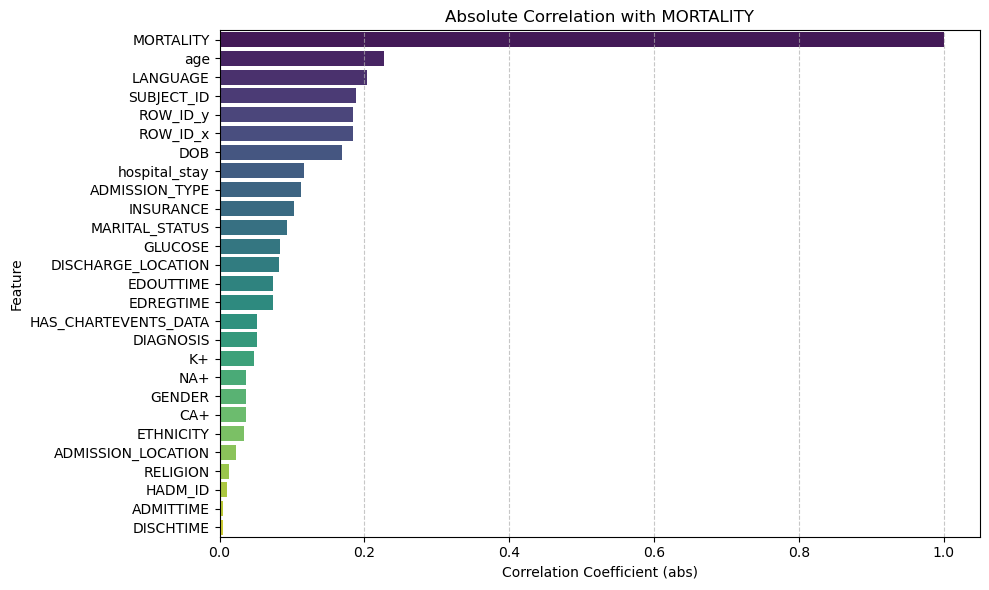

In [57]:
# Step 3: Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Absolute Correlation with MORTALITY')
plt.xlabel('Correlation Coefficient (abs)')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
df_encoded

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,ROW_ID_y,GENDER,DOB,MORTALITY,age,hospital_stay,CA+,GLUCOSE,K+,NA+
1,22,23,152223,11091,11146,0,4,5,2,59,...,20,1,7308,0,71,5.496528,8.000000,113.70,3.830000,139.75
2,23,23,124321,11927,11992,1,5,5,2,35,...,20,1,7308,0,75,6.768056,8.687500,131.50,3.450000,136.50
7,28,28,162569,15996,16069,0,4,5,2,59,...,25,1,10361,0,74,5.364583,8.000000,130.50,4.466667,136.50
10,31,32,175413,14550,14623,0,4,4,1,59,...,28,1,13264,0,45,19.197917,8.457143,125.00,4.071429,143.00
13,34,34,144319,18847,18931,1,1,5,2,35,...,30,1,532,1,304,2.622917,8.600000,116.00,4.800000,143.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58969,58592,98794,190603,5574,5601,0,4,5,2,35,...,46211,1,2898,0,78,4.145833,8.900000,128.25,4.175000,139.00
58970,58593,98797,105447,6734,6765,1,2,0,2,35,...,46212,1,2384,1,88,0.662500,7.850000,163.00,4.600000,148.00
58971,58594,98800,191113,6314,6343,1,1,4,3,35,...,46213,0,11585,0,19,2.742361,7.540000,99.00,3.300000,141.00
58973,58596,98805,122631,20746,20842,0,4,5,3,35,...,46215,1,15535,0,42,8.203472,8.283333,130.50,4.750000,137.50


In [60]:
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

In [72]:
X.shape, y.shape

((21151, 26), (21151,))

In [ ]:
X, y
# No overlap train test sploit
X_train = X.iloc[:19035]
X_test = X.iloc[19035:]  # Start where training data ends

y_train = y.iloc[:19035]
y_test = y.iloc[19035:]  # Start where training data ends

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19035, 26), (2116, 26), (19035,), (2116,))

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [75]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1538
           1       0.93      0.44      0.60       578

    accuracy                           0.84      2116
   macro avg       0.88      0.71      0.75      2116
weighted avg       0.85      0.84      0.82      2116



In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix



# Target and features
target = 'MORTALITY'

# Drop duplicates or rows with missing target
df = df_encoded.dropna(subset=[target]).drop_duplicates()

# Optional: drop columns with zero variance or low correlation manually if needed
# Based on your correlation data, we may drop low-impact ones later if performance is bad

# Define categorical and numerical features
categorical_cols = [
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',
    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'GENDER'
]
numerical_cols = [
    'age', 'hospital_stay', 'CA+', 'GLUCOSE', 'K+', 'NA+', 'HAS_CHARTEVENTS_DATA', 
]

# Fill missing values
df[categorical_cols] = df[categorical_cols].fillna('UNKNOWN')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Split
X = df[categorical_cols + numerical_cols]
y = df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1437  101]
 [ 268  310]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89      1538
           1       0.75      0.54      0.63       578

    accuracy                           0.83      2116
   macro avg       0.80      0.74      0.76      2116
weighted avg       0.82      0.83      0.82      2116



### comparing 4 different models

- Scale X_train and X_test properly.

- Train each model on X_train.

- Predict probabilities on X_test.

- Compute ROC AUC on real test data (not cross-validation).

- Plot a bar chart to easily pick the best model.

Logistic Regression ROC AUC on Test Set: 0.7351
Random Forest ROC AUC on Test Set: 0.8210
Support Vector Machine ROC AUC on Test Set: 0.7528
K-Nearest Neighbors ROC AUC on Test Set: 0.6716


/opt/homebrew/anaconda3/envs/viz/lib/python3.13/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


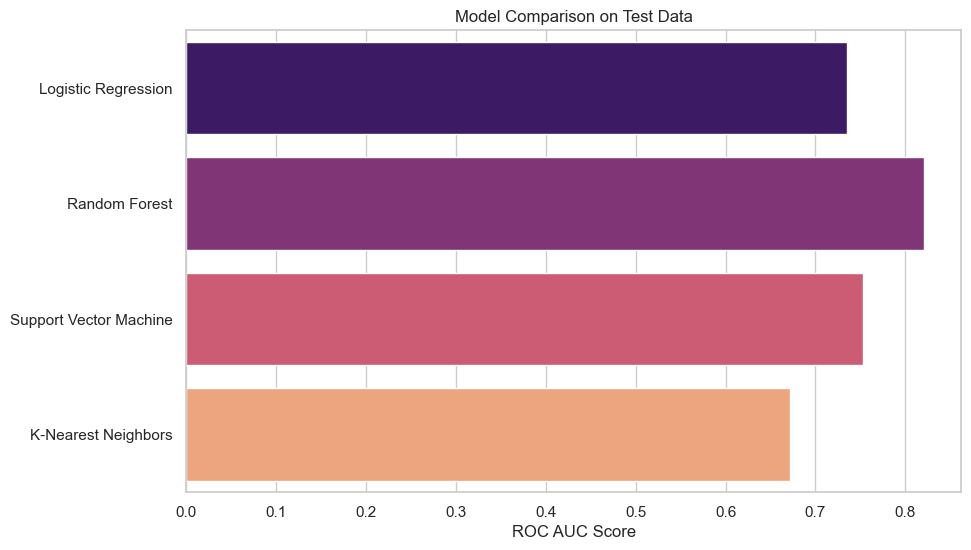

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scale your features (fit scaler only on training data, transform both train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define 4 models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# 3. Train models and evaluate
model_scores = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1
    score = roc_auc_score(y_test, y_pred_proba)
    model_scores[name] = score
    print(f"{name} ROC AUC on Test Set: {score:.4f}")

# 4. Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
model_names = list(model_scores.keys())
scores = list(model_scores.values())
sns.barplot(x=scores, y=model_names, palette="magma")
plt.xlabel('ROC AUC Score')
plt.title('Model Comparison on Test Data')
plt.show()


### hence Random forest is the better model!